# HBV Calibration

## Setup and Data Preparation

In [1]:
%matplotlib inline
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import wasserstein_distance

# Niceties
from rich import print
from tqdm import tqdm


# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
from ewatercycle.models import HBV

# Optional: Data Assimilation
# If not installed, uncomment below to install
# !pip install ewatercycle-da
from ewatercycle_DA import DA

## Choose region and time period

<Axes: >

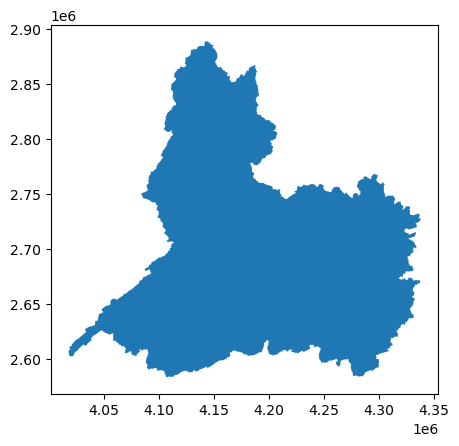

In [2]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"

#check
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

In [3]:
# Location forcing files in home directory
forcing_path = Path.home() / "forcing" / "FR000119"/"ERA5"
forcing_path.mkdir(parents=True, exist_ok=True)

## Generate ERA 5 Forcing

In [4]:
# Option one: generate forcing:
#ERA5_forcing = sources["LumpedMakkinkForcing"].generate(
    #dataset="ERA5",
    #start_time=experiment_start_date,
    #end_time=experiment_end_date,
    #shape=shapefile_path,
#)

# Option two: Load generated (merged) data
forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrep5yvtlv4f_20250525_104347/work/diagnostic/script")
ERA5_forcing = sources["LumpedMakkinkForcing"].load(directory=forcing_dir)

## Defining historical data from eStreams
The original CSV file had some formatting and encoding issues—like strange quotation marks and all the data crammed into a single column—which made it impossible to load with the usual pandas.read_csv() method. To work around this, I used a custom parser to manually extract the dates and discharge values.

In [5]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

## Ensemble Initialization and Parameter Sampling

In [6]:
# Define HBV parameter bounds and names
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
p_min = np.array([0.0,  0.2,   40.0,  0.5,   0.001,   1.0,   0.01,  0.0001,  0.01])
p_max = np.array([8.0,  1.0,  800.0,  4.0,   0.3,    10.0,   0.1,   0.01,   10.0])

n_particles = 1000  # ensemble size
# Sample random parameters for each particle within bounds
parameters = np.zeros((len(param_names), n_particles))
for j in range(len(param_names)):
    parameters[j, :] = np.random.uniform(p_min[j], p_max[j], size=n_particles)

In [8]:
# Create ensemble and initialize each member with HBV model and unique parameters
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()  # set up the ensemble environment

# Prepare setup arguments for each particle (each gets its parameter set)
setup_kwargs_list = [{'parameters': parameters[:, i]} for i in range(n_particles)]

# Initialize all ensemble members with the HBVLocal model, forcing data, and parameters
ensemble.initialize(model_name=["HBVLocal"] * n_particles,
                    forcing=[ERA5_forcing] * n_particles,
                    setup_kwargs=setup_kwargs_list) 

# (Optional) Choose a reference model for time tracking
ref_model = ensemble.ensemble_list[0].model

# Generate config file with first parameter set
config_file, _ = ref_model.setup(parameters=parameters[:, 0])

# Initialize model
ref_model.initialize(config_file)

In [9]:
# Watchout with this!!!
#import shutil
# from pathlib import Path

# # Search for all folders starting with "hbvlocal_"
# work_dir = Path(".")
# folders = [f for f in work_dir.glob("hbvlocal_*") if f.is_dir()]

# # Delete them all
# for folder in folders:
#     print(f"Delete: {folder}")
#     shutil.rmtree(folder)

## Running the Ensemble Simulation

In [10]:
# Determine number of time steps in the simulation period
n_timesteps = int((ref_model.end_time - ref_model.start_time) / ref_model.time_step)

time_index = []           # list to store timestamps for each time step
ensemble_Q_outputs = []   # list to store discharge arrays for each time step

for step in range(n_timesteps):
    # Record current model time
    current_time = pd.Timestamp(ref_model.time_as_datetime.date())
    time_index.append(current_time)
    
    # Advance all models by one time step and collect their discharge values
    ensemble.update()  # update all ensemble members by one step
    Q_values = np.array(ensemble.get_value("Q")).flatten()  # discharge of all particles
    Q_values_m3s = Q_values * basin_area * 1000 / 86400 #convert to m3/s
    ensemble_Q_outputs.append(Q_values_m3s)

# Finalize the ensemble to release resources (important if models run in containers)
ensemble.finalize()

# Convert collected outputs to a DataFrame for convenience
Q_array = np.array(ensemble_Q_outputs)        # shape: (n_timesteps, n_particles)
df_ensemble = pd.DataFrame(
    data=Q_array, 
    index=pd.DatetimeIndex(time_index), 
    columns=[f"particle_{i}" for i in range(n_particles)]
)

In [11]:
print(df_ensemble.shape)
print(df_ensemble.head())

(2555, 1000)

particle_0  particle_1  particle_2  particle_3  particle_4  \
2013-01-01    0.000066    0.000000    0.000000    0.001587    0.000362   
2013-01-02    0.001235    0.000022    0.000690    0.019136    0.002352   
2013-01-03    0.004531    0.000111    0.002065    0.035988    0.006095   
2013-01-04    0.012561    0.000609    8.542215    0.084091    0.014017   
2013-01-05    0.030427    0.002373   29.096132    0.197466    0.043699   

            particle_5  particle_6  particle_7  particle_8  particle_9  ...  \
2013-01-01    0.000000    0.009566    0.000011    0.000095    0.000067  ...   
2013-01-02    0.000000    0.038451    0.000071    0.000558    0.000420  ...   
2013-01-03    0.000000    0.076782    0.000234    0.001735    0.001351  ...   
2013-01-04    0.003612    0.135985    0.000589    0.004157    0.003408  ...   
2013-01-05    0.467988    0.251039    0.001287    0.008582    0.007782  ...   

            particle_990  particle_991  particle_992  particle_993  \
2013-01-01      0.002708      0.000019      0.000000      0.001816   
2013-01-02      0.017966      0.056953      0.000343      0.009281   
2013-01-03      0.034237      0.197568      0.001711      0.021314   
2013-01-04      0.073228      0.479186      0.202499      0.036490   
2013-01-05      0.159058      1.363217      1.224075      0.058434   

            particle_994  particle_995  particle_996  particle_997  \
2013-01-01      0.000019      0.000098      0.001398      0.000020   
2013-01-02      0.000113      0.001940      0.014977      0.001404   
2013-01-03      0.000351      0.007200      0.042813      0.005496   
2013-01-04      0.000837      0.023394      0.086676      0.017837   
2013-01-05      0.001725      0.068075      0.212021      0.050188   

            particle_998  particle_999  
2013-01-01      0.002325      0.000000  
2013-01-02      0.012147      0.000028  
2013-01-03      0.028198      0.000139  
2013-01-04      0.049508      0.000460  
2013-01-05      0.090675      0.001253  

[5 rows x 1000 columns]

## Defining the Calibration Objective

In [12]:
def calibration_objective(simulated_series: pd.Series, observed_series: pd.Series,
                          w_lognse: float = 0.7, w_emd: float = 0.3) -> float:
    """
    Calibrate model by combining:
    - log-NSE: performance during low flows
    - EMD: match drought event characteristics (timing, deficit)
    Weights w_lognse and w_emd define the importance of each.
    Lower total_score indicates better calibration.
    """

    # Align indices
    sim = simulated_series.loc[observed_series.index]
    obs = observed_series

    # 1. log-NSE
    sim_pos = sim[sim > 0]
    obs_pos = obs[obs > 0]
    common_index = sim_pos.index.intersection(obs_pos.index)
    sim_log = np.log(sim_pos.loc[common_index])
    obs_log = np.log(obs_pos.loc[common_index])
    
    numerator = np.sum((sim_log - obs_log) ** 2)
    denominator = np.sum((obs_log - np.mean(obs_log)) ** 2)
    log_nse = 1 - (numerator / denominator) if denominator != 0 else np.inf
    error_nse = 1 - log_nse  # to be minimized

    # 2. EMD from drought characteristics
    obs_droughts = droughts(obs, basin_name="obs", q_crit=500)
    sim_droughts = droughts(sim, basin_name="sim", q_crit=500)

    obs_durations = pd.DataFrame(obs_droughts)["Duration (days)"].values
    sim_durations = pd.DataFrame(sim_droughts)["Duration (days)"].values
    obs_deficits = pd.DataFrame(obs_droughts)["Max Cumulative Deficit (m3/s)"].abs().values
    sim_deficits = pd.DataFrame(sim_droughts)["Max Cumulative Deficit (m3/s)"].abs().values

    emd_duration = wasserstein_distance(obs_durations, sim_durations)
    emd_deficit = wasserstein_distance(obs_deficits, sim_deficits)
    error_emd = emd_duration + emd_deficit

    # Combine with weighted sum
    total_score = w_lognse * error_nse + w_emd * error_emd
    return total_score

In [13]:
print("Q_obs index sample:", Q_obs.index[:3])
print("df_ensemble index sample:", df_ensemble.index[:3])

Q_obs index sample: DatetimeIndex(['2013-11-26 00:00:00+00:00', '2013-11-27 00:00:00+00:00',
               '2013-11-28 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

df_ensemble index sample: DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03'], dtype='datetime64[ns]', 
freq=None)

## Evaluating Performance and Selecting the Best Parameter Set

In [14]:
from critical_days_module import droughts

Exported functions to: critical_days_module.py


In [15]:
# Evaluate objective for each ensemble member
scores = []

# Same datetime-index
Q_obs.index = Q_obs.index.normalize()
Q_obs.index = Q_obs.index.tz_localize(None)

# Slice only the overlap 
Q_obs_aligned = Q_obs.loc[df_ensemble.index.min():df_ensemble.index.max()]

for i in range(n_particles):
    sim_series = df_ensemble[f"particle_{i}"]

    if sim_series is None or sim_series.empty:
        print(f"Skipping particle_{i} (empty output)")
        scores.append(np.inf)  # Assign a bad score
        continue

    # Use the correct observation series (make sure Q_obs exists and matches in index)
    score = calibration_objective(sim_series, Q_obs_aligned)
    scores.append(score)

scores = np.array(scores)
best_index = np.argmin(scores)              # index of minimum objective value
best_score = scores[best_index]             # lowest score
best_params = parameters[:, best_index]     # parameter set corresponding to best score

print(f"Best score: {best_score:.3f} (part {best_index})")

Beste score: 78.981 (deeltje 72)

In [16]:
print("Number of scores:", len(scores))
print("First 5 scores:", scores[:5])

Aantal scores: 1000

Eerste 5 scores: [1962.76187702 1436.39995507  418.9822811   320.18997986 1298.25772133]

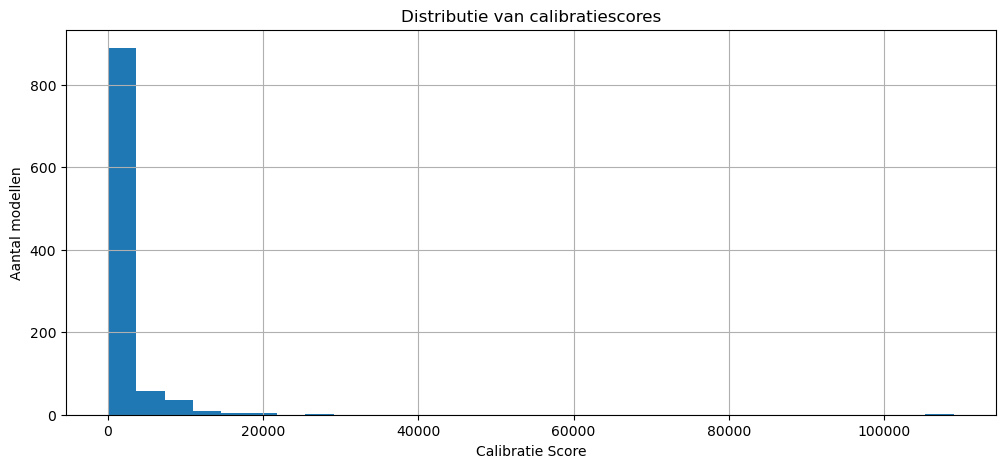

Beste score: 78.981 bij particle index: 72

In [17]:
# Histogram of scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(scores, bins=30)
plt.title("Distributie van calibratiescores")
plt.xlabel("Calibratie Score")
plt.ylabel("Aantal modellen")
plt.grid(True)
plt.show()

# Print best score
print(f"Best score: {best_score:.3f} at particle index: {best_index}")

## Outputting the Optimal Parameters

In [18]:
# Print the best score and parameter set
print(f"Best objective score: {best_score:.4f}")
best_params_list = [round(val, 4) for val in best_params]
print("par_0 =", best_params_list)
print("param_names =", param_names)

Best objective score: 78.9806

par_0 =
[6.3785, 0.9656, 235.0548, 3.8811, 0.2353, 5.3018, 0.0244, 0.0055, 7.4328]

param_names =
['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']